In [1]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 649 kB/s 


In [2]:
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Standard libraries imports
import requests
from scipy import stats
import pyarabic.araby as araby

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# list of all Arabic characters
chars = list('اٱبتةثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىی')
print('Number of Arabic Characters:', len(chars))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(chars))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(chars))

char_to_index['p'] = 0 # pad
char_to_index['s'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = 'p' # pad
index_to_char[1] = 's' # separator
index_to_char[2] = '_' # mask

# additional char_to_index and index_to_char extracted manually as shown in next 
# cells. They were extracted and then saved into a CSV file
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1lQFU7XFy82-1dE5kPK7yDLpJ6tleycCC')
chars_2 = df['char'].values.tolist()
indexes_2 = df['value'].values.tolist()
del df

# additional character to index dictionary
char_to_index_2 = dict(zip(chars_2, indexes_2))
# additional index to character dictionary
index_to_char_2 = dict(zip(indexes_2, chars_2))

Number of Arabic Characters: 38


In [4]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [5]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


In [6]:
valid_df['count'] = valid_df['plural'].apply(lambda x: len(list(x)))
valid_df.head()

,singular,plural,count
0,تهمة,تهم,3
1,مانع,موانع,5
2,بعد,أبعاد,5
3,توظيف,توظيفات,7
4,خطر,أخطار,5


In [7]:
valid_df.iloc[:, -1].value_counts()

5     121
6      87
7      55
4      40
8      20
3      14
9       5
11      1
Name: count, dtype: int64

In [8]:
valid_df.iloc[:, -1].describe()

count    343.000000
mean       5.626822
std        1.284447
min        3.000000
25%        5.000000
50%        5.000000
75%        6.000000
max       11.000000
Name: count, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


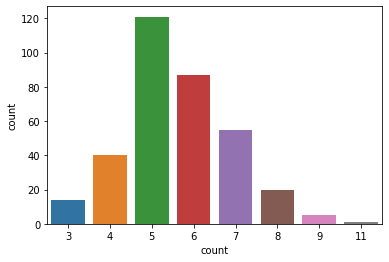

In [10]:
sns.countplot(valid_df.iloc[:, -1])
plt.show()

In [11]:
valid_df = valid_df.iloc[:, :-1]
valid_df.head()

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار


In [12]:
def indexes_to_word(example):
  '''
  Args: an array of indexes
  Returns: a list of characters
  '''
  example = example.tolist()
  list_of_chars = [index_to_char[idx] for idx in example]
  return list_of_chars

In [13]:
def final_prediction_as_chars(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of characters of the predictions from the start to the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  example = np.int32(predicted_flipped_example).tolist()
  # convert indexes into characters
  pred_chars = [index_to_char[i] for i in example]
  # if gold is required, return it
  if return_gold:
    gold = list(valid_df.iloc[index, 1])
    return pred_chars, gold
  return pred_chars

In [14]:
def final_prediction_as_indexes(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of indexes of the predictions from the start to the index of the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  # flip the predictions (Arabic)
  flipped_example = np.flip(example)
  # find the position of the first separator index, which is 1
  first_separator_index = np.where(flipped_example == 1)[0][0]
  # limit the returned sequence to the first separator
  predicted_flipped_example = flipped_example[:first_separator_index]
  # convert the array into a list
  pred_indexes = np.int32(predicted_flipped_example).tolist()
  # if gold is required, return it
  if return_gold:
    gold = [char_to_index[char] for char in list(valid_df.iloc[index, 1])]
    return pred_indexes, gold
  return pred_indexes

In [15]:
def arabic_leven_dis(gold, pred, return_matrix=False):
  '''
  Levenshtein distance
  Args:
    gold: list of indexes of the gold characters
    pred: list of indexes of the predicted characters
  Returns:
    Levenshtein distance
  '''

  # construct a matrix of the correct size
  sol = np.zeros((len(pred), len(gold)))

  # first row and column
  sol[0, :] = np.flip([i for i in range(len(gold))])
  sol[:, -1] = [i for i in range(len(pred))]

  # fill in the rest
  # through every column
  for c in reversed(range(len(gold) - 1)):
    # through every row
    for r in range(1, len(pred)):

      # in case not the same corresponding letters, take the minimum value of the above right corner three values (Arabic) + 1 
      if gold[c] != pred[-(r+1)]:
        sol[r, c] = min(sol[r-1, c+1], sol[r-1, c], sol[r, c+1]) + 1
      # in case the corresponding letters are the same, take the upper diagonal value
      else:
        sol[r, c] = sol[r-1, c+1]

  # if the full matrix is required
  if return_matrix: 
    return sol
  # if only the minimum number of edits is required
  return sol[-1, 0]

In [16]:
def final_prediction_as_chars(index, return_gold=False):
  '''
  Args: index in the preditions array, int
  Returns: a list of characters of the predictions from the start to the first 's' character
  '''
  # extract the predictions
  example = preds[index]
  pred_chars = [index_to_char[i] for i in example]
  # if gold is required, return it
  if return_gold:
    gold = list(valid_df.iloc[index, 1])
    return pred_chars, gold
  return pred_chars

In [17]:
# load the predictions
url = 'https://drive.google.com/uc?export=download&id=1--skMnBkyyGzcZbt0BS6Bef5pQHiuwJC'
r = requests.get(url, allow_redirects=True)
open('validation_set_prediction.npy', 'wb').write(r.content)
# read the predictions NumPy array
with open('/content/validation_set_prediction.npy', 'rb') as f:
  preds = np.load(f)

In [18]:
# construct a distances list
distances = []
# iterate over each plural example in the validation set
for i in range(len(valid_df)):
  # extract the final predicted indexes alongside with the ground truth ones
  pred, gold = final_prediction_as_indexes(i, True)
  gold = gold + [-1] # add -1 for the '#' in the Levenshtein distance
  pred = pred + [-1] # add -1 for the '#' in the Levenshtein distance
  # calculate the minimum edits required
  dist = arabic_leven_dis(gold, pred)
  # append the distance to the distances list
  distances.append(dist)

# convert the distances list into a NumPy array
distances = np.array(distances)

In [19]:
# print the statistics of the distances array
statistics = stats.describe(distances)
statistics

DescribeResult(nobs=343, minmax=(0.0, 5.0), mean=1.6909620991253644, variance=1.7697133991441187, skewness=0.19061563579058655, kurtosis=-0.9124238351854728)

In [20]:
# the whole dataset
# count the masculine, feminine, and takseer forms based on the word endings
feminine_counts = 0
masculine_counts = 0
takseer_counts = 0

# create lists to collect their indexes
feminine_indexes = []
masculine_indexes = []
takseer_indexes = []

# go over each word and check whether it is masculine, feminine, or takseer
for i, word in enumerate(valid_df.iloc[:, -1].values.tolist()):
  if word[-2:] == 'ات':
    feminine_counts += 1
    feminine_indexes.append(i)
  elif word[-2:] == 'ين':
    masculine_counts += 1
    masculine_indexes.append(i)
  else:
    takseer_counts += 1
    takseer_indexes.append(i)

print('Number of feminine examples:', feminine_counts)
print('Number of masculine examples:', masculine_counts)
print('Number of takseer examples:', takseer_counts)

Number of feminine examples: 146
Number of masculine examples: 50
Number of takseer examples: 147


In [21]:
# print(count of each Levenshtein distance)
dists = np.unique(np.int32(distances), return_counts=True)[0]
couts = np.unique(np.int32(distances), return_counts=True)[1]
display(pd.DataFrame({'Distance': dists, 'Counts': couts}))

,Distance,Counts
0,0,95
1,1,48
2,2,103
3,3,66
4,4,27
5,5,4


In [22]:
# group by each distance value
zero_distance_indexes = np.where(distances==0)[0]
one_distance_indexes = np.where(distances==1)[0]
two_distance_indexes = np.where(distances==2)[0]
three_distance_indexes = np.where(distances==3)[0]
four_distance_indexes = np.where(distances==4)[0]
five_distance_indexes = np.where(distances==5)[0]

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# down the data file for the gradients from this link: https://drive.google.com/file/d/11VBml_G8VAbBYhH9M4vtPjISHldpk3q4/view?usp=sharing
# then upload it to the content/ path and read it using the following code
with open('/content/interpritibility_grads.pkl', 'rb') as f:
  grads = pickle.load(f)

# with open('/content/drive/MyDrive/NLP_Course/interpritibility_grads.pkl', 'rb') as f:
#   grads = pickle.load(f)

In [26]:
def norm_abs_grads(example, pass_, part):
  '''
  Args: 
    example: str, the example name, e.g. 'example_0'
    pass_: str, the pass name, e.g. 'pass_0'
    part: str, part to extract the gradients. There are three choices: 'cbert_grads', 'encoder_grads', and 'decoder_grads'

  Returns:
    normalized summed gradients: for each position, the absolute value of the gradients are taken and then summed
  '''
  max_abs_grad = np.max(np.sum(np.abs(grads[example][pass_][1][part]), axis=-1))
  min_abs_grad = np.min(np.sum(np.abs(grads[example][pass_][1][part]), axis=-1))
  nomralized_absolute_gradients = (np.sum(np.abs(grads[example][pass_][1][part]), axis=-1) - min_abs_grad) / (max_abs_grad - min_abs_grad)
  return nomralized_absolute_gradients

In [27]:
def per_example_df(example, part):
  '''
  Args:
    example: str, the example name, e.g. 'example_0'
    part: str, part to extract the gradients. There are three choices: 'cbert_grads', 'encoder_grads', and 'decoder_grads'

  Returns:
    df: containing the full sequence with the corresponding gradients
  '''
  arr = np.zeros((17, 17))
  for i in range(17):
    arr[i, :] += norm_abs_grads(example, f'pass_{i}', part)

  df = pd.DataFrame(arr, columns=[i for i in reversed(range(17))])
  df['Pass'] = np.arange(17)

  first_end_idx = np.where(grads[example]['pass_0'][0]['cbert_input_ids'] == 1)[0][0]
  to_display = 17 - first_end_idx

  df = df.iloc[:to_display, -(to_display+1):]
  return df

In [28]:
def parallel_plot(df, title, enc=True):

  '''
  Inputs:
      df: a dataframe that contains the data to plot
      title: to be used in the plot
      enc: boolean to define the part provided in the dataframe
  '''

  pd.plotting.parallel_coordinates(
      df, 'Pass', color=('black', 'grey', 'red', 'gold', 'cyan', 'blue', 'steelblue'), linestyle='-', alpha=0.7,
      axvlines_kwds={'alpha': 0.5, 'color':'grey', 'linestyle':':', 'linewidth':1.5})
  plt.grid(linestyle=':', linewidth=1.5, color='grey')
  plt.xlabel('Character Position')
  plt.ylabel('Nomralized Summed Absolute Gradients')
  if enc:
    list_enc = ['s', 'ذ', 'ر', 'ي', 'ع', 'ة', 's']
    list_enc.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6], list_enc)
  else:
    list_dec = ['s', 'ذ', 'ر', 'ا', 'ئ', 'ع', 's']
    list_dec.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6], list_dec)

  plt.legend([f'Pos {i}' for i in range(len(df))])
  plt.title(title)

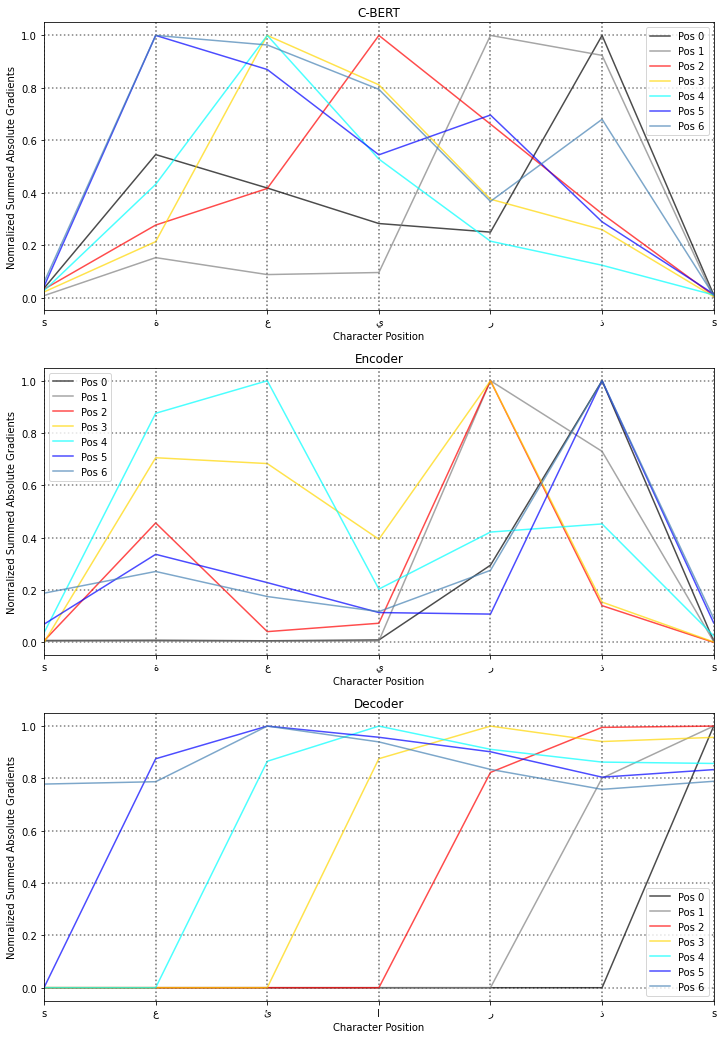

In [29]:
# zero edits (ذريعة ---- ذرائع)
df_1 = per_example_df('example_308', 'cbert_grads')
df_2 = per_example_df('example_308', 'encoder_grads')
df_3 = per_example_df('example_308', 'decoder_grads')

plt.figure(figsize=(12, 6*3))
plt.subplot(3, 1, 1)
parallel_plot(df_1, 'C-BERT', True)
plt.subplot(3, 1, 2)
parallel_plot(df_2, 'Encoder', True)
plt.subplot(3, 1, 3)
parallel_plot(df_3, 'Decoder', False)
plt.savefig('parallet_plots_308.png', dpi=100, bbox_inches='tight')
plt.show()

In [30]:
def per_example_df(example, part):
  '''
  Args:
    example: str, the example name, e.g. 'example_0'
    part: str, part to extract the gradients. There are three choices: 'cbert_grads', 'encoder_grads', and 'decoder_grads'

  Returns:
    df: containing the full sequence with the corresponding gradients
  '''
  arr = np.zeros((17, 17))
  for i in range(17):
    arr[i, :] += norm_abs_grads(example, f'pass_{i}', part)

  df = pd.DataFrame(arr, columns=[i for i in reversed(range(17))])
  df['Pass'] = np.arange(17)

  first_end_idx = np.where(grads[example]['pass_0'][0]['cbert_input_ids'] == 1)[0][0]
  to_display = 17 - first_end_idx + 1

  df = df.iloc[:to_display, -(to_display+1):]
  return df

In [31]:
def parallel_plot(df, title, enc=True):
  pd.plotting.parallel_coordinates(
      df, 'Pass', color=('black', 'grey', 'red', 'gold', 'cyan', 'blue', 'steelblue'), linestyle='-', alpha=0.7,
      axvlines_kwds={'alpha': 0.5, 'color':'grey', 'linestyle':':', 'linewidth':1.5})
  plt.grid(linestyle=':', linewidth=1.5, color='grey')
  plt.xlabel('Character Position')
  plt.ylabel('Nomralized Summed Absolute Gradients')
  if enc:
    list_enc = ['s', 'م', 'ب', 'ع', 'و', 'ث', 's', 'p']
    list_enc.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], list_enc)
  else:
    list_dec = ['s', 'م', 'ب', 'ع', 'و', 'ث', 'ي', 'ن']
    list_dec.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], list_dec)

  plt.legend([f'Pos {i}' for i in range(len(df))])
  plt.title(title)

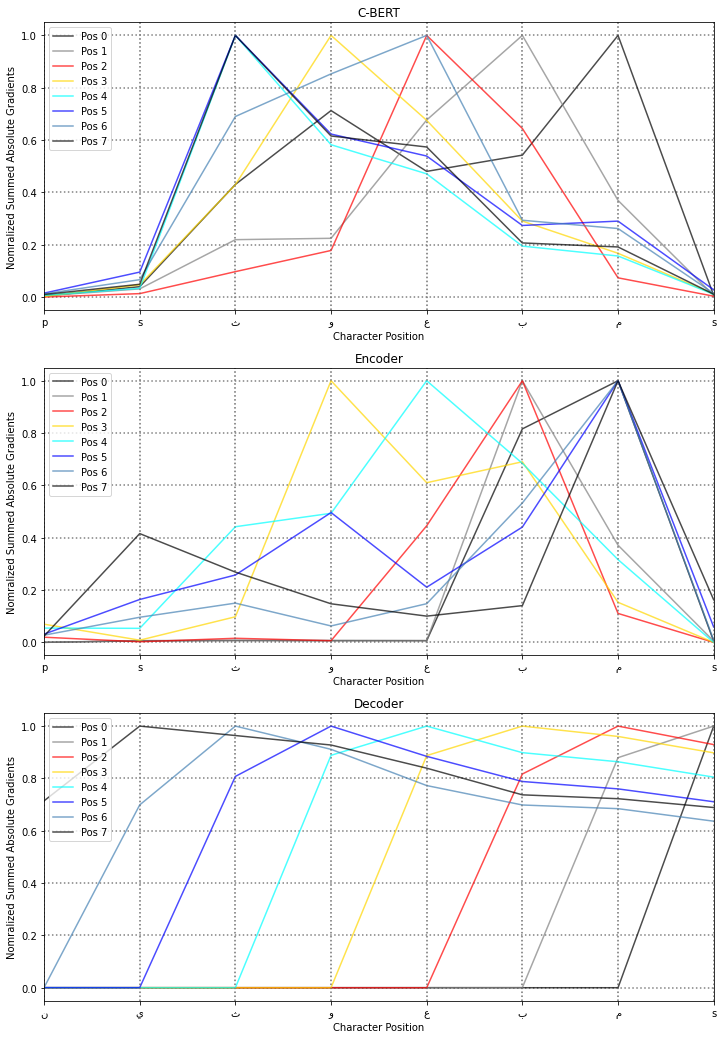

In [32]:
# zero edits (مبعوث ---- مبعوثين)
df_1 = per_example_df('example_32', 'cbert_grads')
df_2 = per_example_df('example_32', 'encoder_grads')
df_3 = per_example_df('example_32', 'decoder_grads')

plt.figure(figsize=(12, 6*3))
plt.subplot(3, 1, 1)
parallel_plot(df_1, 'C-BERT', True)
plt.subplot(3, 1, 2)
parallel_plot(df_2, 'Encoder', True)
plt.subplot(3, 1, 3)
parallel_plot(df_3, 'Decoder', False)
plt.savefig('parallet_plots_32.png', dpi=100, bbox_inches='tight')
plt.show()

In [33]:
def per_example_df(example, part):
  '''
  Args:
    example: str, the example name, e.g. 'example_0'
    part: str, part to extract the gradients. There are three choices: 'cbert_grads', 'encoder_grads', and 'decoder_grads'

  Returns:
    df: containing the full sequence with the corresponding gradients
  '''
  arr = np.zeros((17, 17))
  for i in range(17):
    arr[i, :] += norm_abs_grads(example, f'pass_{i}', part)

  df = pd.DataFrame(arr, columns=[i for i in reversed(range(17))])
  df['Pass'] = np.arange(17)

  first_end_idx = np.where(grads[example]['pass_0'][0]['cbert_input_ids'] == 1)[0][0]
  to_display = 17 - first_end_idx + 1

  df = df.iloc[:to_display, -(to_display+1):]
  return df

In [34]:
def parallel_plot(df, title, enc=True):
  '''
  Inputs: 
      df: dataframe to be plotted
      title: str for the title of the plot
      enc: wether the plot is for the encoder or decoder

  Returns:
    no returns are provided. The function provides a parallel coordinate plot for the queried dataframe
  '''
  pd.plotting.parallel_coordinates(
      df, 'Pass', color=('black', 'grey', 'red', 'gold', 'cyan', 'blue', 'steelblue'), linestyle='-', alpha=0.7,
      axvlines_kwds={'alpha': 0.5, 'color':'grey', 'linestyle':':', 'linewidth':1.5})
  plt.grid(linestyle=':', linewidth=1.5, color='grey')
  plt.xlabel('Character Position')
  plt.ylabel('Nomralized Summed Absolute Gradients')
  if enc:
    list_enc = ['s', 'ن', 'ز', 'ا', 'ع', 's', 'p']
    list_enc.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6], list_enc)
  else:
    list_dec = ['s', 'ن', 'ز', 'ا', 'ع', 'ا', 'ت']
    list_dec.reverse()
    plt.xticks([0, 1, 2, 3, 4, 5, 6], list_dec)

  plt.legend([f'Pos {i}' for i in range(len(df))])
  plt.title(title)

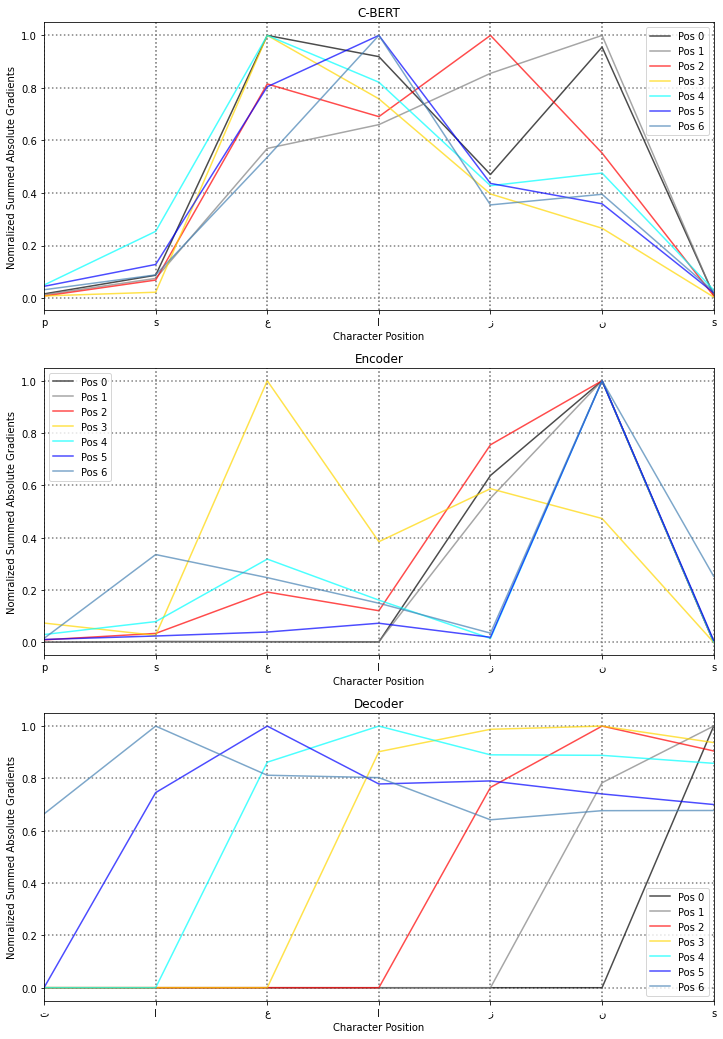

In [35]:
# zero edits (نزاع ---- نزاعات)
# create CBERT df
df_1 = per_example_df('example_9', 'cbert_grads')
# create encoder df
df_2 = per_example_df('example_9', 'encoder_grads')
# create decoder df
df_3 = per_example_df('example_9', 'decoder_grads')

# use functions to plot
plt.figure(figsize=(12, 6*3))
plt.subplot(3, 1, 1)
parallel_plot(df_1, 'C-BERT', True)
plt.subplot(3, 1, 2)
parallel_plot(df_2, 'Encoder', True)
plt.subplot(3, 1, 3)
parallel_plot(df_3, 'Decoder', False)
plt.savefig('parallet_plots_9.png', dpi=100, bbox_inches='tight')
plt.show()

# Heatmap

In [36]:
def per_group_parallel_plot(df, title):
  '''
  Args:
    df: dataframe with values to plot
    title: str for the title of the plot
  Returns:
    no returns are provided. The function provides a parallel coordinate plot for the queried dataframe
  '''
  df['Pass'] = np.arange(17)
  
  fig = px.parallel_coordinates(df, color="Pass", labels=list(reversed(range(17))), dimensions=list(reversed(range(17))), 
                              color_continuous_scale=px.colors.qualitative.Vivid, 
                              title=title)
  fig.show()

In [37]:
def all_grads(example, part):
  '''
  Args:
    example: str, the example name, e.g. 'example_0'
    part: str, part to extract the gradients. There are three choices: 'cbert_grads', 'encoder_grads', and 'decoder_grads'

  Returns:
    no returns are provided. The function provides a parallel coordinate plot for the queried example and part
  '''
  arr = np.zeros((17, 17))
  for i in range(17):
    arr[i, :] += norm_abs_grads(example, f'pass_{i}', part)

  new_df = pd.DataFrame(arr, columns=[i for i in reversed(range(17))])
  
  return new_df

In [38]:
def create_df(part, indexes):
  # group by distance
  '''
  Inputs: 
      part: to be used ('cbert_grads', 'encoder_grads', 'decoder_grads')
      indexes: to be sliced

  Returns:
      df: a dataframe sliced on the indexes with the corresponding gradients
  '''
  df = pd.DataFrame((np.zeros((17, 17))), columns=list(reversed(range(17))))
  for i in range(len(valid_df)):
    if i in indexes:
      df += all_grads(f'example_{i}', part)

  df = df / len(indexes)
  return df

In [39]:
def heatmap_plot(df, title, savefig_title):
  '''
  Inputs:
      df: dataframe returned by create_df function
      title: to use in the plots
      savefig_title: title to save the figure with

  Returns:
      no returns, rather the function provieds a heatmap plot
  '''
  plt.figure(figsize=(15, 15))
  ax = sns.heatmap(df, cmap='coolwarm', center=0.25, robust=True, fmt='.4f', 
                  annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                  cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
      
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
  plt.title(title, fontdict={'fontsize':18},    pad=14)
  plt.savefig(savefig_title, dpi=100)
  plt.show()

# All Dataset

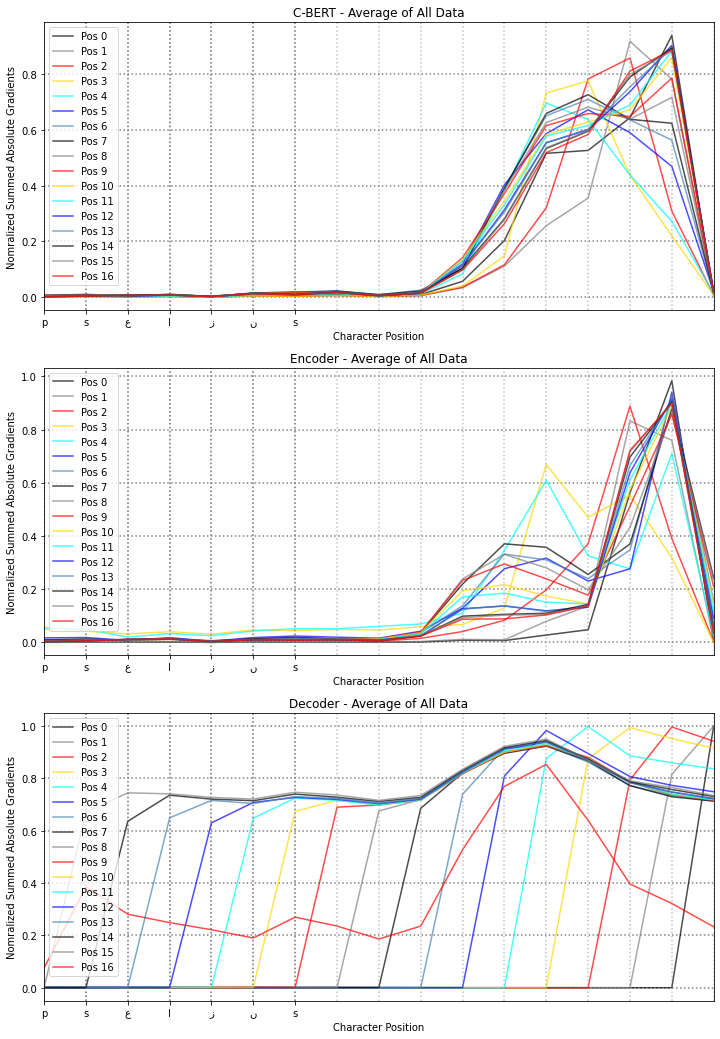

In [41]:
# all data

# create CBERT df
df_1 = pd.DataFrame((np.zeros((17, 17))), columns=list(reversed(range(17))))
for i in range(len(valid_df)):
  df_1 += all_grads(f'example_{i}', 'cbert_grads')
df_1 = df_1 / len(valid_df)
df_1['Pass'] = np.arange(17)

# create the encoder df
df_2 = pd.DataFrame((np.zeros((17, 17))), columns=list(reversed(range(17))))
for i in range(len(valid_df)):
  df_2 += all_grads(f'example_{i}', 'encoder_grads')
df_2 = df_2 / len(valid_df)
df_2['Pass'] = np.arange(17)

# create the decoder df
df_3 = pd.DataFrame((np.zeros((17, 17))), columns=list(reversed(range(17))))
for i in range(len(valid_df)):
  df_3 += all_grads(f'example_{i}', 'decoder_grads')
df_3 = df_3 / len(valid_df)
df_3['Pass'] = np.arange(17)

# plot the parallel coordinates plot
plt.figure(figsize=(12, 6*3))
plt.subplot(3, 1, 1)
parallel_plot(df_1, 'C-BERT - Average of All Data')
plt.subplot(3, 1, 2)
parallel_plot(df_2, 'Encoder - Average of All Data')
plt.subplot(3, 1, 3)
parallel_plot(df_3, 'Decoder - Average of All Data')
plt.savefig('parallet_plots_all_data.png', dpi=100, bbox_inches='tight')
plt.show()

In [43]:
# create CBERT df (zero Levenshtein distance)
string = 'cbert'
df_4 = create_df(string + '_grads', zero_distance_indexes)
df_4['Pass'] = np.arange(17)

# create encoder df (zero Levenshtein distance)
string = 'encoder'
df_5 = create_df(string + '_grads', zero_distance_indexes)
df_5['Pass'] = np.arange(17)

# create decoder df (zero Levenshtein distance)
string = 'decoder'
df_6 = create_df(string + '_grads', zero_distance_indexes)
df_6['Pass'] = np.arange(17)

# create CBERT df (five Levenshtein distance)
string = 'cbert'
df_7 = create_df(string + '_grads', five_distance_indexes)
df_7['Pass'] = np.arange(17)

# create encoder df (five Levenshtein distance)
string = 'encoder'
df_8 = create_df(string + '_grads', five_distance_indexes)
df_8['Pass'] = np.arange(17)

# create decoder df (five Levenshtein distance)
string = 'decoder'
df_9 = create_df(string + '_grads', five_distance_indexes)
df_9['Pass'] = np.arange(17)

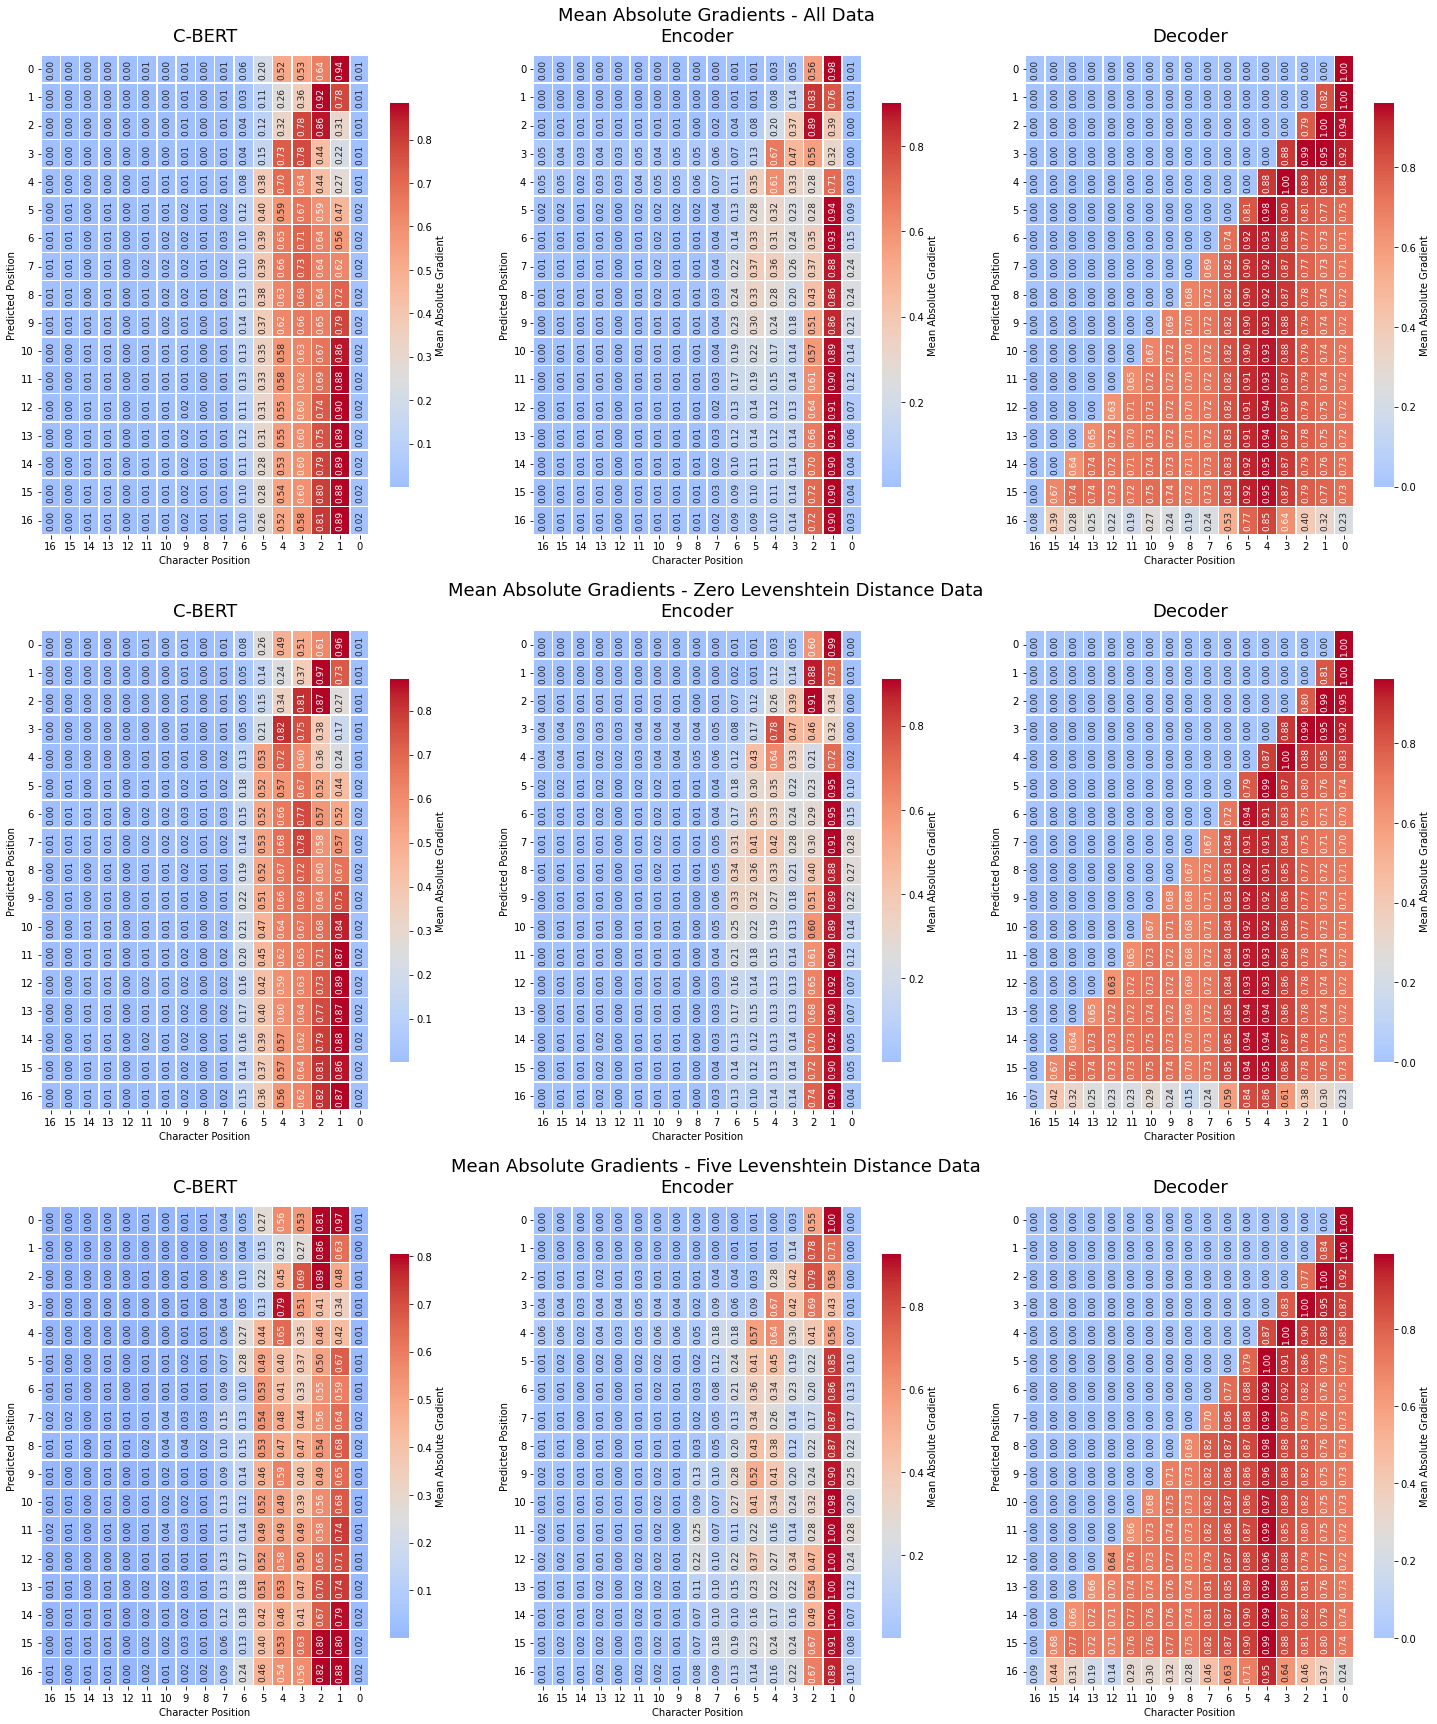

In [44]:
# heat map plots for the three groups
# build the figure
fig, _ = plt.subplots(3, 3, figsize=(25, 10*3))
# define subplots
plt.subplot(3, 3, 1)
# heat map plot for all data - CBERT
ax = sns.heatmap(df_1.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('C-BERT', fontdict={'fontsize':18}, pad=14)

# define subplots
plt.subplot(3, 3, 2)
# heat map plot for all data - Encoder
ax = sns.heatmap(df_2.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Encoder', fontdict={'fontsize':18},    pad=14)

# define subplots
plt.subplot(3, 3, 3)
# heat map plot for all data - Decoder
ax = sns.heatmap(df_3.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Decoder', fontdict={'fontsize':18},    pad=14)


plt.text(.5, 0.896, 'Mean Absolute Gradients - All Data', transform=fig.transFigure, horizontalalignment='center', fontsize=18)

###################################################################
# define subplots
plt.subplot(3, 3, 4)
# heat map plot for zero Levenshtein distance - CBERT
ax = sns.heatmap(df_4.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('C-BERT', fontdict={'fontsize':18}, pad=14)

# define subplots
plt.subplot(3, 3, 5)
# heat map plot for zero Levenshtein distance - Encoder
ax = sns.heatmap(df_5.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Encoder', fontdict={'fontsize':18},    pad=14)

# define subplots
plt.subplot(3, 3, 6)
# heat map plot for zero Levenshtein distance - Decoder
ax = sns.heatmap(df_6.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Decoder', fontdict={'fontsize':18},    pad=14)


plt.text(.5, .63, 'Mean Absolute Gradients - Zero Levenshtein Distance Data', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
###################################################################
# define subplots
plt.subplot(3, 3, 7)
# heat map plot for five Levenshtein distance - CBERT
ax = sns.heatmap(df_7.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('C-BERT', fontdict={'fontsize':18}, pad=14)

# define subplots
plt.subplot(3, 3, 8)
# heat map plot for five Levenshtein distance - Encoder
ax = sns.heatmap(df_8.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Encoder', fontdict={'fontsize':18},    pad=14)

# define subplots
plt.subplot(3, 3, 9)
# heat map plot for five Levenshtein distance - Decoder
ax = sns.heatmap(df_9.drop('Pass', axis=1), cmap='coolwarm', center=0.25, robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':9, 'rotation': 90}, 
                 cbar_kws={'shrink':.8, 'label':'Mean Absolute Gradient'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.xlabel('Character Position')
plt.ylabel('Predicted Position')
plt.title('Decoder', fontdict={'fontsize':18},    pad=14)

# plt.suptitle('Mean Absolute Gradients - All Data', fontsize=18)
plt.text(.5, .363, 'Mean Absolute Gradients - Five Levenshtein Distance Data', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
###################################################################

plt.savefig('heatmap_all_data.png', dpi=100, bbox_inches='tight')
plt.show()